In [69]:
import torch
import torchtext.legacy.data as data

SEED = 1234
import pandas as pd
import numpy as np
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext

import nltk

import random
from sklearn.metrics import classification_report

import pyprind

import spacy
spacy_en = spacy.load('en_core_web_sm')



# ARGUMENTS
'''Training types: totally blinded (no BERT embeddings), partial BERT/Glove embeddings, only words with BERT/Glove embeddings'''
import  doq

# DATA LOADING ---------------------------------------
# Load the data
data_doq = doq.load_and_preprocess_ACLED(200)
print(len(data_doq))

# Create new dataframe with feature (note)
data_doq_fat = data_doq[data_doq['FATALITIES'] != 0]

df = data_doq_fat[['NOTES', 'FATALITIES']].copy()

def split_train_test_valid(data, ratio_train, ratio_test):

    n_data = len(data)
    n_train = int(n_data * ratio_train)
    n_test = int(n_data * ratio_test)
    data_train = data.iloc[:n_train]
    data_test = data.iloc[n_train:(n_train + n_test)]
    data_valid = data.iloc[(n_train + n_test) :]

    return data_train, data_test, data_valid

data_train, data_test, data_valid = split_train_test_valid(df, 0.5, 0.4)

data_train.to_csv('torchtext_data/train.csv', index =False)
data_test.to_csv('torchtext_data/test.csv', index =False)
data_valid.to_csv('torchtext_data/valid.csv', index =False)
del data_train, data_test, data_valid, df, data_doq, data_doq_fat


is_cuda = torch.cuda.is_available()
print("Cuda Status on system is {}".format(is_cuda))

# sample tokenizer which you can use
def tokenizer(text):
    return [tok for tok in nltk.word_tokenize(text)]

# tokenizer = "spacy" uses spacy's tokenizer
TEXT = data.Field(sequential=True, tokenize="spacy")
LABEL = data.Field(dtype=torch.long, sequential=False) # changed from data.LabelField
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# loading train, test and validation data 
train_data, valid_data, test_data = data.TabularDataset.splits(
    path="torchtext_data/", train="train.csv", 
    validation="valid.csv", test="test.csv",format="csv", skip_header=True, 
    fields=[('Text', TEXT), ('Label', LABEL)]
)

print(f'Number of training examples: {len(train_data)}')
print(f'Number of valid examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

TEXT.build_vocab(train_data, vectors=torchtext.vocab.Vectors("../embeddings/glove.840B.300d.txt"), 
                 max_size=20000, min_freq=10)
LABEL.build_vocab(train_data)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

BATCH_SIZE = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# keep in mind the sort_key option 
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), sort_key=lambda x: len(x.Text),
    batch_size=BATCH_SIZE,
    device=device)


Csv file exists already, check whether it contains the desired data.
200
Cuda Status on system is False
/Users/leoniemuggenthaler/Desktop/MasterThesis/doq_for_conflict/.nlp_env/lib/python3.8/site-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')
Number of training examples: 21
Number of valid examples: 5
Number of testing examples: 16
Unique tokens in TEXT vocabulary: 15
Unique tokens in LABEL vocabulary: 7


In [153]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):

        #x = [sent len, batch size]
        
        embedded = self.embedding(x)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        out = self.fc(hidden)
        return out

In [331]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 374
OUTPUT_DIM = 10

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data = pretrained_embeddings
#class_weights = torch.tensor([1.0, 15.0, 15, 15,15, 15, 15,15, 15, 15 ])
optimizer = optim.Adagrad(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [332]:
def get_label(prediction):
    ind = -100
    try:
        preds, ind= torch.max(prediction, 1)
    except:
        pass
    return ind

In [333]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    bar = pyprind.ProgBar(len(iterator), bar_char='█')
    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = F.softmax(model(batch.Text).squeeze(0), dim = -1)
        loss = criterion(predictions, batch.Label)
        
#         print(loss.shape)
        acc = binary_accuracy(predictions, batch.Label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        bar.update()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [327]:

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    preds, ind= torch.max(preds, 1)
    correct = (ind == y).float()
    acc = correct.sum()/float(len(correct))
    return acc

In [334]:
loss = []
acc = []
for epoch in range(20):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    loss.append(train_loss)
    acc.append(train_acc)
    #print(train_loss, train_acc)



0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
0% [███████████] 100% | ETA: 00:00:00
Total time elapsed: 00:0

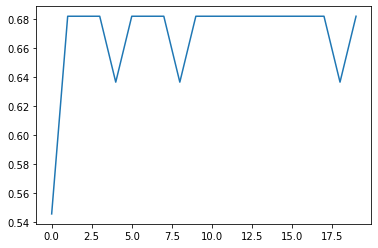

In [335]:
import matplotlib.pyplot as plt
plt.plot(acc)

In [330]:
for batch in valid_iterator:
    print(batch.Label)
    print(torch.max(F.softmax(model(batch.Text).squeeze(0), dim = -1), dim = 1))
    break

tensor([1, 1])
torch.return_types.max(
values=tensor([1.0000, 1.0000], grad_fn=<MaxBackward0>),
indices=tensor([1, 1]))
